In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cv2
from sklearn import svm

In [ ]:
# Fetch the MNIST dataset
ds = fetch_openml('mnist_784', as_frame=False)

In [ ]:
# Convert the data to a DataFrame
data = pd.DataFrame(ds.data)
labels = pd.Series(ds.target.astype(int))

# Stores the final dataset (1000 for each digit)
final_data = pd.DataFrame()
final_labels = pd.Series()

# Loop through each digit (0-9)
for digit in range(10):
    digit_samples = data[labels == digit]
    sampled_digit = digit_samples.sample(n=1000, random_state=42)
    final_data = pd.concat([final_data, sampled_digit])
    final_labels = pd.concat([final_labels, pd.Series([digit] * 1000)])

# Convert to arrays
final_data = final_data.values
final_labels = final_labels.values

# Normalize the data (very important)
final_data = final_data / 255.0

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(final_data, final_labels, test_size=0.2, random_state=42)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# Display a image (28, 28)
a = x_train[0].reshape((28,28))
plt.imshow(a)

In [ ]:
# Resize to (14, 14)
a_resize = cv2.resize(a, (14,14))
plt.imshow(a_resize)

x_train_resize = np.zeros((x_train.shape[0], 196))
for i in range(x_train.shape[0]):
  x_train_resize[i] = cv2.resize(x_train[i].reshape((28,28)), (14,14)).reshape(196)

x_test_resize = np.zeros((x_test.shape[0], 196))
for i in range(x_test.shape[0]):
  x_test_resize[i] = cv2.resize(x_test[i].reshape((28,28)), (14,14)).reshape(196)

In [ ]:
# Define and fit the classifier
classifier = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
classifier.fit(x_train_resize, y_train)

In [ ]:
# Use the classifier to predict the test data
y_pred = classifier.predict(x_test_resize)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)

In [ ]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

In [ ]:
conf_matrix_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix_result)

In [ ]:
# Search for a better hyper-parameter C
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 500, 1000]  # Values of C to try
}

# Create the GridSearchCV object
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(x_train_resize, y_train)

# Show all the results in a table
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')
print(results[['param_C', 'mean_test_score', 'rank_test_score']])

# Print the best hyper-parameters
print("Best hyper-parameters:", grid_search.best_params_)

In [ ]:
# Use the best classifier to predict the test data
y_pred = grid_search.best_estimator_.predict(x_test_resize)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)


In [ ]:
# Create a smaller dataset for the next task
# Training dataset - 100 samples, validation dataset - 100 samples, no test dataset
# Previous training dataset has 8000 samples, validation dataset has 2000 samples
# Randomly select 100 samples from the training dataset and 100 samples from the validation dataset

# Training dataset
x_train_small = np.zeros((100, 196))
y_train_small = np.zeros(100)
for i in range(100):
    idx = np.random.randint(0, 8000)
    x_train_small[i] = x_train_resize[idx]
    y_train_small[i] = y_train[idx]

# Validation dataset
x_val_small = np.zeros((100, 196))
y_val_small = np.zeros(100)
for i in range(100):
    idx = np.random.randint(0, 2000)
    x_val_small[i] = x_test_resize[idx]
    y_val_small[i] = y_test[idx]

In [ ]:
from skimage.filters import gabor_kernel, gabor

# freq, theta, bandwidth = 0.1, np.pi / 4, 1
freq, theta, bandwidth = 0.05, 0, 0.3
gk = gabor_kernel(frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(1); plt.clf(); plt.imshow(gk.real)
plt.figure(2); plt.clf(); plt.imshow(gk.imag)

# convolve the input image with the kernel and get co-efficients
# we will use only the real part and throw away the imaginary
# part of the co-efficients
image = x_train_small[0].reshape((14,14))
coeff_real, _ = gabor(image, frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(3); plt.clf(); plt.imshow(coeff_real)

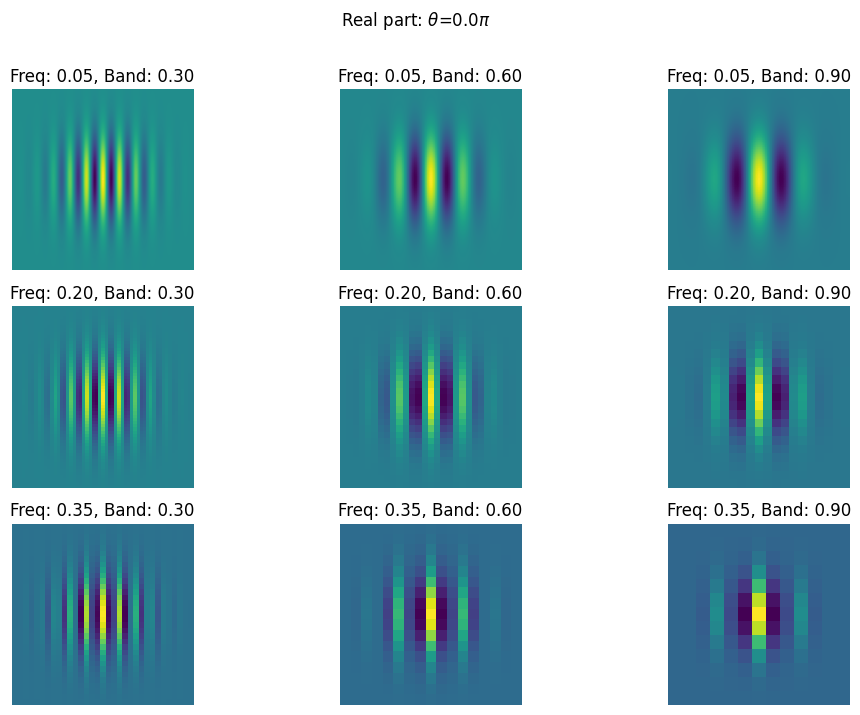

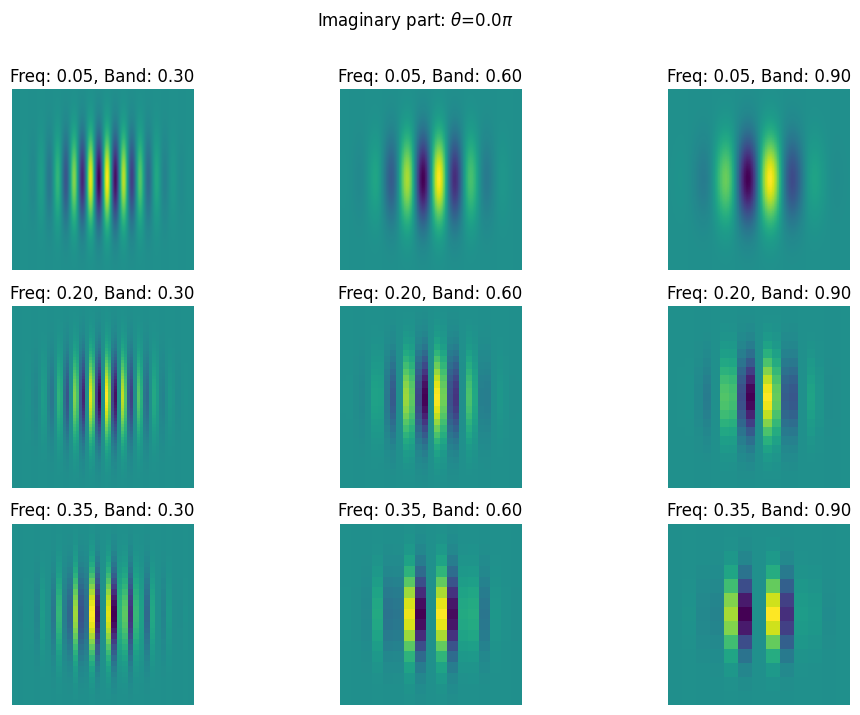

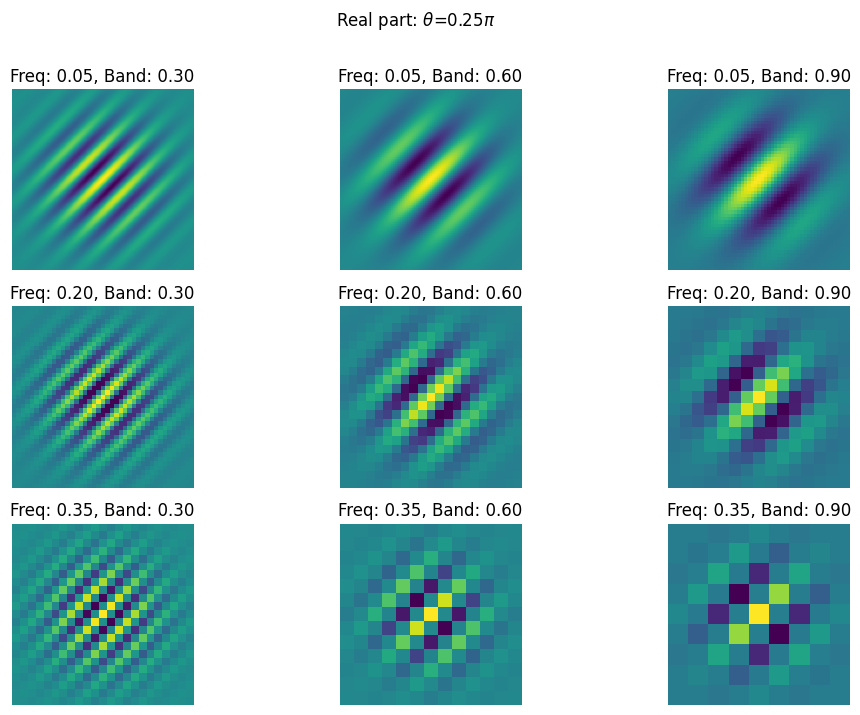

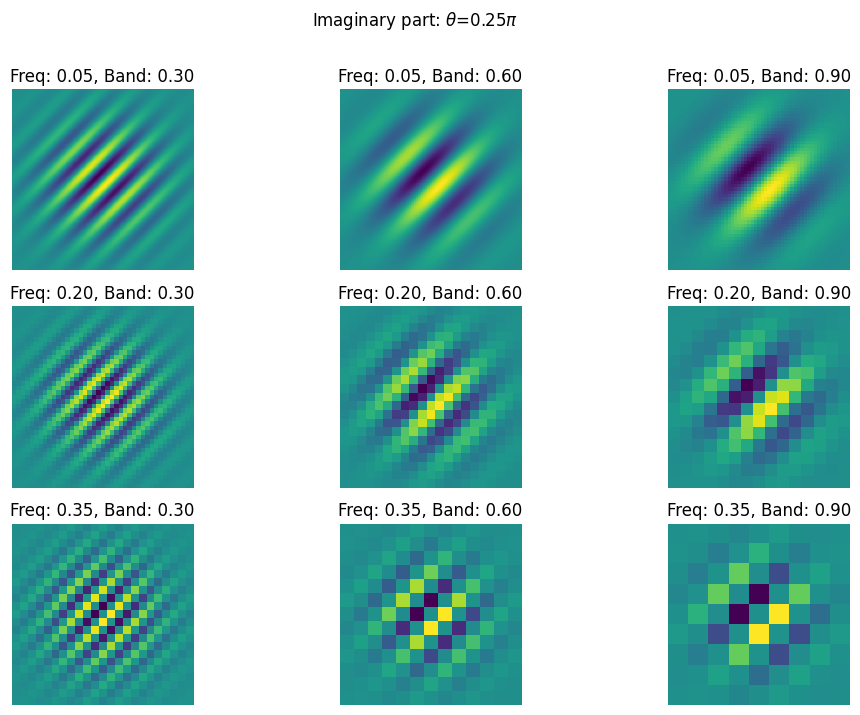

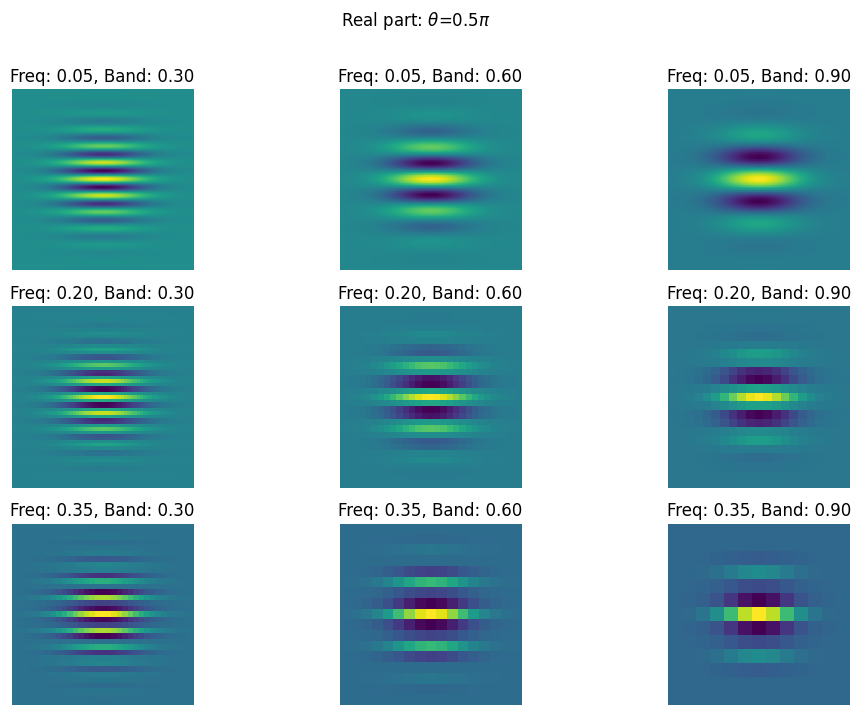

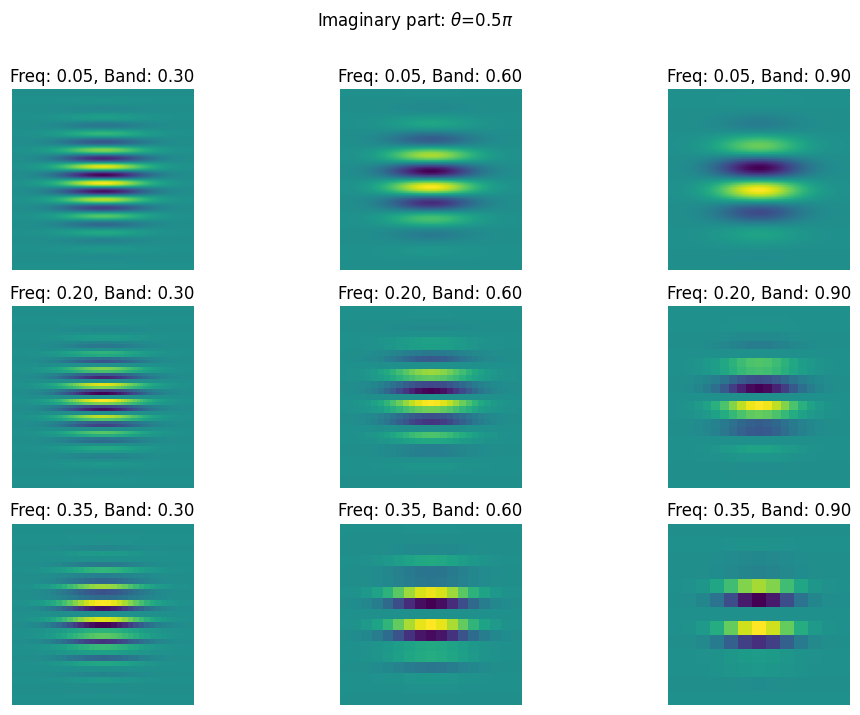

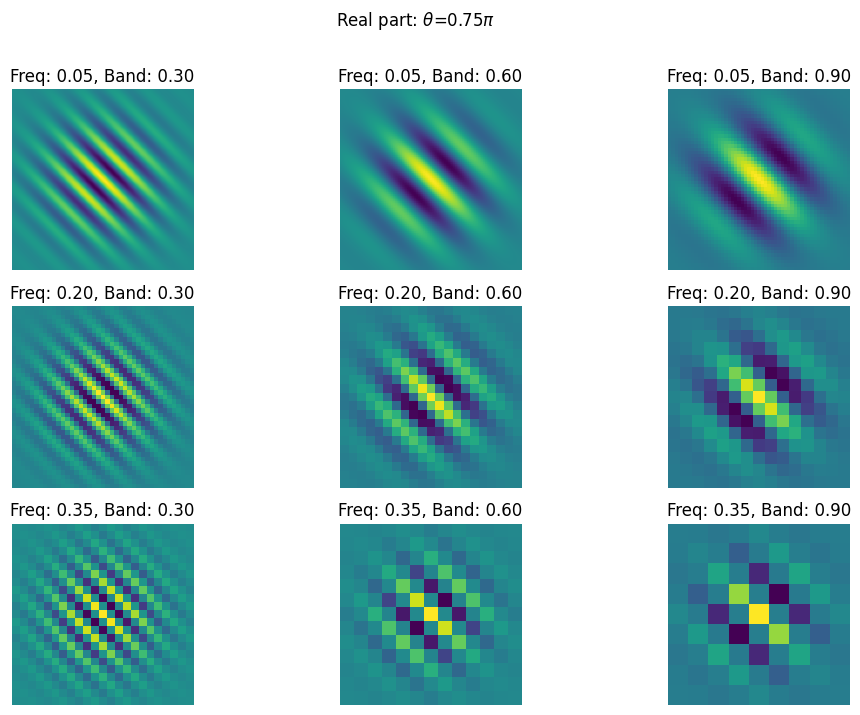

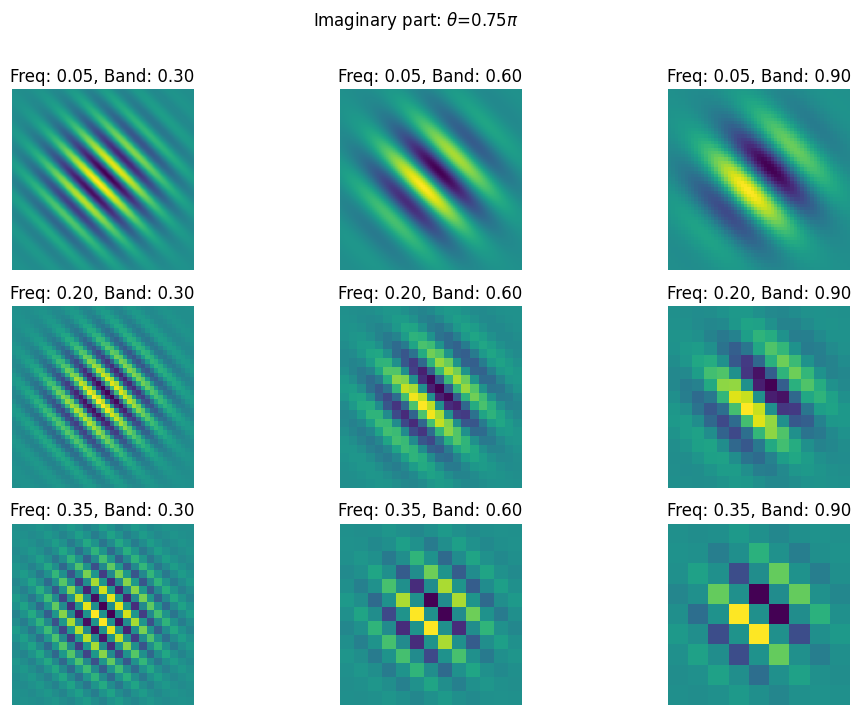

In [33]:
theta_arr = np.arange(0, np.pi, np.pi / 4)
frequency_arr = np.arange(0.05, 0.5, 0.15)
bandwidth_arr = np.arange(0.3, 1.0, 0.3)

filter_bank = []

for t in theta_arr:
    fig_real, axs_real = plt.subplots(len(frequency_arr), len(bandwidth_arr), figsize=(12, 8))
    fig_imag, axs_imag = plt.subplots(len(frequency_arr), len(bandwidth_arr), figsize=(12, 8))
    fig_real.suptitle(fr'Real part: $\theta$={t/np.pi}$\pi$')
    fig_imag.suptitle(fr'Imaginary part: $\theta$={t/np.pi}$\pi$')
    for i, f in enumerate(frequency_arr):
        for j, b in enumerate(bandwidth_arr):
            gk = gabor_kernel(frequency=f, theta=t, bandwidth=b)
            filter_bank.append(gk)
            image = x_train_small[0].reshape((14,14))
            coeff_real, _ = gabor(image, frequency=f, theta=t, bandwidth=b)
            axs_real[i, j].imshow(gk.real)
            axs_imag[i, j].imshow(gk.imag)
            axs_real[i, j].set_title(f'Freq: {f:.2f}, Band: {b:.2f}')
            axs_imag[i, j].set_title(f'Freq: {f:.2f}, Band: {b:.2f}')
            axs_real[i, j].axis('off')
            axs_imag[i, j].axis('off')
    plt.show(fig_real)
    plt.show(fig_imag)
    plt.close(fig_real)
    plt.close(fig_imag)